# Machine learning for sentiment classification on movie reviews

This project aims at compare several classification algorithms and textual data representations with their parameters, on a dataset of movies reviews classified as positive or negative.
We experiment a representation as bag of words (CountVectorizer) and 3 classification algorithms:
 - Multinomial Naive Bayes
 - Logistic regression, with two different solvers: bilinear and lbfgs
 - SVM, with two different kernels: linear and RBF

For each classifier we follow the same layout:
 1. We try to find the best parameters by using grid-search and cross-validation on the relevant parameters (alpha for Multinomial Naive Bayes, C for the logistric regression, gamma and C for SVM), based on accurracy score.
 2. We evaluate the classifier on the test set, by using with common metrics: accuracy and area under ROC curve, and also compute the confusion matrix.

Finally we investigate the use of bidirectional LSTM for our classification task.

In [1]:
# load common librairies
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Load data

First the data is transformed into pandas dataframes by some file manipulation. We use the Polarity dataset v2.0 of [Bo Pang and Lillian Lee, ACL 2004], which is available at: http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

In [2]:
# load dedicated library
import os

In [3]:
# preprocessing: prepare data
col_names = ['content', 'label']
pos = pd.DataFrame(columns = col_names)
neg = pd.DataFrame(columns = col_names)

In [4]:
# add positive samples to the DataFrame structure
i=1
for fend in os.listdir('./dataset1/pos/'):
    #data = pd.read_csv('./dataset1/pos/'+fend, sep = None, header = None)
    file = open('./dataset1/pos/'+fend, 'r')
    data = file.read()
    #print(data)
    file.close()
    pos = pos.append(pd.DataFrame({'content':[data], 'label':int(1)}, index=[i]))
    i+=1
# add negative samples to the DataFrame structure
i=1
for fend in os.listdir('./dataset1/neg/'):
    #data = pd.read_csv('./dataset1/neg/'+fend, sep = None, header = None)
    file = open('./dataset1/neg/'+fend, 'r')
    data = file.read()
    file.close()
    neg = neg.append(pd.DataFrame({'content':[data],'label':int(-1)}, index=[i]))
    i+=1

In [5]:
# convert label to a numerical variable
#reviews["label_num"] = reviews.label.map({"1":int(1), "-1":int(0)})
pos["label_num"] = pos['label'].astype(int)
neg["label_num"] = neg['label'].astype(int)

In [6]:
# print
print('pre-processing done')
print('number of positive samples: {} '.format(len(pos)))
print('number of negative samples: {} '.format(len(neg)))
print()
print('last positive samples:')
print(pos.tail(5))
print()
print('last negative samples:')
print(neg.tail(5))

pre-processing done
number of positive samples: 1000 
number of negative samples: 1000 

last positive samples:
                                                content label  label_num
996   wow ! what a movie . \nit's everything a movie...     1          1
997   richard gere can be a commanding actor , but h...     1          1
998   glory--starring matthew broderick , denzel was...     1          1
999   steven spielberg's second epic film on world w...     1          1
1000  truman ( " true-man " ) burbank is the perfect...     1          1

last negative samples:
                                                content label  label_num
996   if anything , " stigmata " should be taken as ...    -1         -1
997   john boorman's " zardoz " is a goofy cinematic...    -1         -1
998   the kids in the hall are an acquired taste . \...    -1         -1
999   there was a time when john carpenter was a gre...    -1         -1
1000  two party guys bob their heads to haddaway's d...    -1

## Prepare learn and test sets

Then we mix the 2 dataframes of positive and negative samples into 2 random dataframes dedicated to training and testing. We verified that the random split was always done in the same way (with the same seed) to ensure that the results are the same every time we run the code.

In [7]:
# concat positive and negative samples
reviews = pos.append(neg)

In [8]:
# define X (items) and y (labels)
X = reviews.content
y = reviews.label_num

In [9]:
# split randomly X and y into train and test sets (NB: always uses the same seed)
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)

In [10]:
# print
print('number of train samples: {}'.format(len(X_train)))
print('number of test samples: {}'.format(len(X_test)))
print()
print('first train samples with their labels:')
print(X_train.head(10))
print(y_train.head(10))
#print()
#print('first test samples with their labels:')
#print(X_test.head(10))
#print(y_test.head(10))

number of train samples: 1500
number of test samples: 500

first train samples with their labels:
651    james cmaeron's breakthrough feature was the f...
105    this is not a simple plan about finding a plan...
562    the seasoned capt . dudley smith ( james cromw...
644    in `enemy at the gates' , jude law is a gifted...
442    call me crazy , but i don't see saving private...
629    writer/director lawrence kasdan had a hand in ...
997    john boorman's " zardoz " is a goofy cinematic...
681    it is an understood passion and an understood ...
813    seen april 16 , 1999 at 10 p . m . at crossgat...
505    american pie 2 is filled with laughs . \nbut t...
Name: content, dtype: object
651    1
105   -1
562    1
644    1
442    1
629   -1
997   -1
681    1
813    1
505   -1
Name: label_num, dtype: int32


## Representing text as numerical data (vectorization)

In order to use text as input of the classification algorithms, we need to convert it into fixed-size numerical feature vectors. To do so we use scikit-learn CountVectorizer that "converts text into a matrix of token counts", or "bag of words". It first learns the vocabulary over the text given as input, and then transforms any textual data into a document-term matrix using the fitted vocabulary. We learn the vocabulary on the training dataset, and compute the document-term matrix representations for both training and testing data. The basic method uses the input token as such in the vocabulary, but it's also possible to use methods of natural language processing to use more elaborated tokens. We concentrated at the first, by analyzing the impact of the parameters of the CountVectorizer with two sets of parameters (cf. the sumup of our results for the comparison with default parameters).

In [11]:
# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=10, max_df=0.33, ngram_range=(1, 3), stop_words='english')

In [12]:
# learn the "vocabulary" of the training data (occurs in-place)
%time vect.fit(X_train)

Wall time: 8.34 s


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.33, max_features=None, min_df=10,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
# examine the fitted vocabulary
vocabulary = vect.get_feature_names()
print('number of words in the vocabulary: {} '.format(len(vocabulary)))
vocabulary

number of words in the vocabulary: 7641 


['000',
 '10',
 '10 minutes',
 '10 scale',
 '10 scale scale',
 '100',
 '100 million',
 '101',
 '11',
 '12',
 '13',
 '137',
 '13th',
 '14',
 '15',
 '15 minutes',
 '16',
 '17',
 '18',
 '19',
 '1960',
 '1960s',
 '1970',
 '1970s',
 '1971',
 '1973',
 '1976',
 '1977',
 '1978',
 '1980',
 '1980s',
 '1981',
 '1984',
 '1985',
 '1987',
 '1988',
 '1989',
 '1990',
 '1990s',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '19th',
 '19th century',
 '20',
 '20 minutes',
 '200',
 '2000',
 '2001',
 '20th',
 '20th century',
 '21',
 '22',
 '24',
 '25',
 '30',
 '30 minutes',
 '3000',
 '35',
 '40',
 '45',
 '50',
 '500',
 '50s',
 '60',
 '60s',
 '70',
 '70s',
 '80',
 '80s',
 '85',
 '90',
 '90 minutes',
 '90s',
 '95',
 '97',
 '98',
 '99',
 'aaron',
 'abandon',
 'abandoned',
 'abilities',
 'ability',
 'able',
 'able make',
 'aboard',
 'abound',
 'abruptly',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorbed',
 'absorbing',
 'absurd',
 'abuse',
 'abusive',
 'abyss',
 

In [14]:
# transform training data into a "document-term matrix'
X_train_dtm = vect.transform(X_train)
X_train_dtm

<1500x7641 sparse matrix of type '<class 'numpy.int64'>'
	with 293142 stored elements in Compressed Sparse Row format>

In [15]:
# examine the content of the sparse matrix
print(X_train_dtm)

  (0, 32)	5
  (0, 89)	1
  (0, 371)	1
  (0, 396)	1
  (0, 412)	1
  (0, 416)	2
  (0, 417)	2
  (0, 423)	1
  (0, 425)	1
  (0, 429)	1
  (0, 430)	1
  (0, 600)	1
  (0, 644)	1
  (0, 789)	1
  (0, 848)	1
  (0, 872)	1
  (0, 879)	1
  (0, 902)	1
  (0, 937)	1
  (0, 942)	7
  (0, 1098)	1
  (0, 1126)	1
  (0, 1174)	1
  (0, 1213)	1
  (0, 1251)	1
  :	:
  (1499, 7269)	1
  (1499, 7272)	1
  (1499, 7364)	1
  (1499, 7365)	1
  (1499, 7366)	1
  (1499, 7378)	1
  (1499, 7414)	2
  (1499, 7420)	1
  (1499, 7451)	1
  (1499, 7452)	1
  (1499, 7466)	1
  (1499, 7474)	1
  (1499, 7479)	1
  (1499, 7480)	1
  (1499, 7493)	1
  (1499, 7509)	1
  (1499, 7526)	1
  (1499, 7547)	1
  (1499, 7550)	1
  (1499, 7552)	2
  (1499, 7560)	1
  (1499, 7570)	1
  (1499, 7582)	1
  (1499, 7595)	2
  (1499, 7609)	2


In [16]:
# examine the vocabulary and document-term matrix together (X_train_dtm.toarray() converts sparse matrix to a dense matrix)
pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names())

,000,10,10 minutes,10 scale,10 scale scale,100,100 million,101,11,12,...,youngsters,youth,zane,zany,zellweger,zero,zeta,zeta jones,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<500x7641 sparse matrix of type '<class 'numpy.int64'>'
	with 99070 stored elements in Compressed Sparse Row format>

## 1. Class prediction with Multinomial Naive Bayes

The first classifier we test here is a classical one for textual data represented as bag of words, and the combination of these two was a reference until the explosion of deep learning. So it's a good start to have a feeling of the performance we can get on our dataset. The use is really simple with scikit-learn, since it stands in 3 lines for the training and 1 line for a prediction on test data. More, this method has the advantage to have really low computation time, and not to require lots of training data like deep learning methods. It has 3 parameters (from scikit-learn documentation):
 - alpha: additive (Laplace/Lidstone) smoothing parameter (default=1.0, 0 for no smoothing)
 - fit_prior: whether to learn class prior probabilities or not. If false, a uniform prior will be used (default=True)
 - class_prior: enables to give one's own prior probabilities to the classes. If specified the priors are not adjusted according to the data (default=None)

Here we already know that the 2 classes are equaly distributed, so the fit_prior parameter has no impact: we will get the same results by computing prior probabilities or by imposing a uniform distribution. And we don't try other priors either as it would give worse results. However alpha has a real impact that we evaluate in the next.

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [18]:
# import scikit-learn library
from sklearn.naive_bayes import MultinomialNB

### Finding the best parameters with grid-search and cross-validation

We evaluate the impact of the parameter alpha and try to find the best value with 1D grid search cross-validation.

In [19]:
# define the set of parameters
alpha_range = [1.0e-10, 0.001, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8] #0 not accepted in MultinomialNB and automatically mapped to 1.0e-10
param_grid = dict(alpha=alpha_range)

In [20]:
# operate grid search
grid = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=3, return_train_score=True)
%time grid.fit(X_train_dtm, y_train)

Wall time: 859 ms


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-10, 0.001, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [21]:
# print results
print("The best alpha is %s with a score of %0.2f" % (grid.best_params_['alpha'], grid.best_score_))
scores = grid.cv_results_['mean_test_score']
print("Scores for the complete set of parameters are:")
print(scores)

The best alpha is 6 with a score of 0.81
Scores for the complete set of parameters are:
[0.75333333 0.786      0.80333333 0.804      0.80533333 0.80533333
 0.80333333 0.80466667 0.80666667 0.806      0.80666667 0.80733333
 0.80733333 0.806     ]


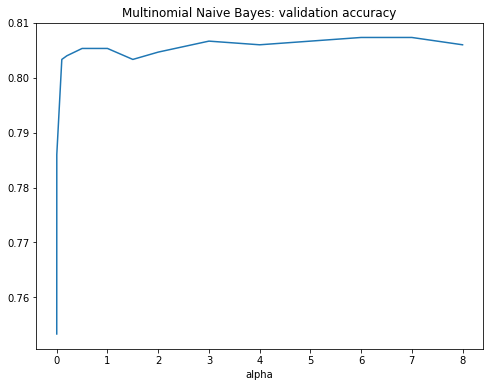

In [22]:
# plot scores
plt.figure(figsize=(8, 6))
plt.plot(alpha_range, scores)
plt.xlabel('alpha')
plt.title('Multinomial Naive Bayes: validation accuracy')
plt.show()

### Performance evaluation on test set

In [23]:
# instantiate and train a Multinomial Naive Bayes model with the alpha parameter found previously
MNB = MultinomialNB(alpha=grid.best_params_['alpha'], fit_prior=False)
%time MNB.fit(X_train_dtm, y_train)

Wall time: 9.92 ms


MultinomialNB(alpha=6, class_prior=None, fit_prior=False)

In [24]:
# make class predictions for X_test_dtm
%time y_pred_class = MNB.predict(X_test_dtm)

Wall time: 1.95 ms


In [25]:
# calculate accuracy of class predictions
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy is: {}'.format(accuracy))

accuracy is: 0.812


In [26]:
# calculate predicted probabilities for X_test_dtm and AUC
y_pred_prob = MNB.predict_proba(X_test_dtm)[:, 1]
AUC = metrics.roc_auc_score(y_test, y_pred_prob)
print('area under ROC curve is: {}'.format(round(AUC,3)))

area under ROC curve is: 0.887


In [27]:
# print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_class)
print('confusion matrix is:')
print(conf_mat)

confusion matrix is:
[[195  50]
 [ 44 211]]


In [28]:
# optional: print reviews for the false positives
FP = X_test[(y_pred_class==1) & (y_test==-1)]
print('there are {} false positive samples:'.format(len(FP)))
print(FP)

there are 50 false positive samples:
683    often similar to a little boy lost in a park t...
822    it's difficult to expect much from a director ...
927    star wars : ? episode i -- the phantom menace ...
762    weighed down by tired plot lines and spielberg...
403    in the interest of being generous , i want to ...
481    as any reasonable human being would , i must a...
87     lucas was wise to start his star wars trilogy ...
315    since director steven zaillian previously wrot...
238    there is a scene early in jakob the liar that ...
29     a follow-up to disney's live-action " 101 dalm...
541    whether or not i would be considered a trekker...
244    i read the new yorker magazine and i enjoy som...
168    so , it's thirty years later , and oscar and f...
263    it's not a bad thing to update old stories . \...
603    by phil curtolo " madonna - antonio banderas -...
633    guilt . guilt is something i felt while watchi...
786    for a film touted as exploring relationships

In [29]:
# optional: print reviews for the false negatives
FN = X_test[(y_pred_class==-1) & (y_test==1)]
print('there are {} false negative samples:'.format(len(FN)))
print(FN)

there are 44 false negative samples:
448    what is a scary movie anyhow ? \nis it a movie...
632    what surprises me most about the long-awaited ...
283    ok , let's get one thing straight right away :...
694    let me first say that the conditions that i wa...
305    one of the best things about my job is that , ...
656    jacques tati's 1953 classic " les vacances de ...
127    i have to say it . \ntim burton's retelling of...
373    okay , let me first say , this is a beavis and...
995    a thriller set in modern day seattle , that ma...
987    i think the first thing this reviewer should m...
701    let me start off by saying that leading up to ...
556    harmless , silly and fun comedy about dim-witt...
762    film adaptation of hunter s . thompson's infam...
349    bob the happy bastard's quickie review : \nthe...
390    when i left the theater after seeing david lyn...
271    this british import follows the ( mis- ) adven...
988    trees lounge is the directoral debut from on

## 2. Class prediction with logistic regression

A second common classification method is logistic regression, which is also provided by scikit-learn. The main parameters are (from scikit-learn documentation):
 - solver: algorithm to use in the optimization problem, among ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ (default: ‘liblinear’, but will be changed to 'lbfgs' in scikit-learn v0.22)
 - max_iter: maximum number of iterations taken for the solvers ‘newton-cg’, ‘sag’ and ‘lbfgs’ to converge
 - penalty: norm used in the penalization (‘l1’ or ‘l2’, default: ‘l2’).
 - dual: use of dual or primal formulation (default: False). Dual formulation is only implemented for l2 penalty.
 - tol: tolerance for stopping criteria (default: 1e-4)
 - C: inverse of regularization strength (default: 1.0). Like in SVMs, smaller values specify stronger regularization.
 - fit_intercept: whether a constant (a.k.a. bias or intercept) should be added to the decision function (default: True), with another particular parameter (intercept_scaling) for the solver ‘liblinear’.

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [30]:
# import and instantiate a logistic regression model 
from sklearn.linear_model import LogisticRegression

## 2.1. Logistic regression with liblinear solver

We first use the liblinear solver which is actually the default solver in scikit-learn.
We optimize the choice for the regularization parameter C with cross-validation.

### Finding the best parameter with grid-search and cross-validation

In [31]:
# define the set of parameters
C_range = np.logspace(-5, 8, 14)
param_grid = dict(C=C_range)
param_grid

{'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
        1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08])}

In [32]:
# operate grid search with liblinear solver
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=param_grid, cv=3, return_train_score=True)
%time grid.fit(X_train_dtm, y_train)

Wall time: 5.44 s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [33]:
# print results
print("The best C is %s with a score of %0.2f" % (grid.best_params_['C'], grid.best_score_))
scores = grid.cv_results_['mean_test_score']
scores

The best C is 0.1 with a score of 0.82


array([0.60066667, 0.69      , 0.79266667, 0.81333333, 0.81533333,
       0.81466667, 0.808     , 0.80533333, 0.78866667, 0.78266667,
       0.77866667, 0.77866667, 0.77866667, 0.77866667])

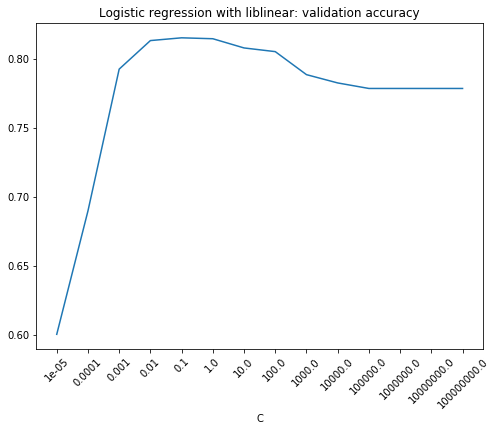

In [34]:
# plot scores
plt.figure(figsize=(8, 6))
plt.plot(scores)
plt.xticks(np.arange(len(C_range)), C_range, rotation=45)
plt.xlabel('C')
plt.title('Logistic regression with liblinear: validation accuracy')
plt.show()

### Performance evaluation on test set

In [35]:
# instantiate and train a logistic regression model with liblinear solver the C parameter found previously
logreg = LogisticRegression(solver='liblinear', C=grid.best_params_['C'])
%time logreg.fit(X_train_dtm, y_train)

Wall time: 155 ms


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
# make class predictions for X_test_dtm
%time y_pred_class = logreg.predict(X_test_dtm)

Wall time: 1.98 ms


In [37]:
# calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy is: {}'.format(accuracy))

accuracy is: 0.836


In [38]:
# calculate predicted probabilities for X_test_dtm and area under ROC curve
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
AUC = metrics.roc_auc_score(y_test, y_pred_prob)
print('area under ROC curve is: {}'.format(round(AUC,3)))

area under ROC curve is: 0.907


In [39]:
# print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_class)
print('confusion matrix is:')
print(conf_mat)

confusion matrix is:
[[207  38]
 [ 44 211]]


## 2.2. Logistic regression with lbfgs solver

The default solver for logistic regression will be changed to 'lbfgs' in scikit-learn v0.22. So it may be useful to try it.
We optimize the choice for the regularization parameter C with cross-validation.

### Finding the best parameter with grid-search and cross-validation

In [40]:
# define the set of parameters
C_range = np.logspace(-5, 8, 14)
param_grid = dict(C=C_range)
param_grid

{'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
        1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08])}

In [41]:
# operate grid search with lbfgs solver
grid = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=400), param_grid=param_grid, cv=3, return_train_score=True)
%time grid.fit(X_train_dtm, y_train)

Wall time: 6.08 s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=400, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [42]:
# print results
print("The best C is %s with a score of %0.2f" % (grid.best_params_['C'], grid.best_score_))
scores = grid.cv_results_['mean_test_score']
scores

The best C is 0.1 with a score of 0.82


array([0.54133333, 0.73333333, 0.77533333, 0.81333333, 0.818     ,
       0.80933333, 0.80666667, 0.804     , 0.8       , 0.808     ,
       0.806     , 0.80733333, 0.80733333, 0.80733333])

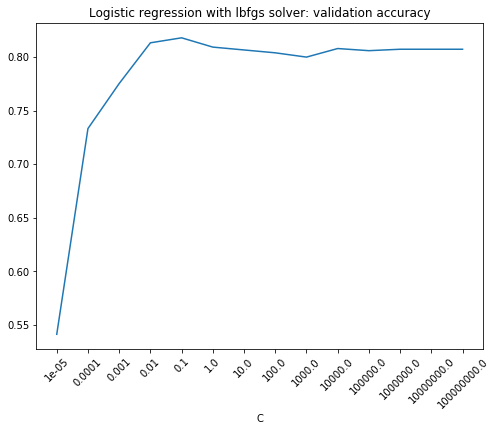

In [43]:
# plot scores
plt.figure(figsize=(8, 6))
plt.plot(scores)
plt.xticks(np.arange(len(C_range)), C_range, rotation=45)
plt.xlabel('C')
plt.title('Logistic regression with lbfgs solver: validation accuracy')
plt.show()

### Performance evaluation on test set

In [44]:
# instantiate and train a logistic regression model with lbfgs solver and the C parameter found previously
logreg = LogisticRegression(solver='lbfgs', max_iter=400, C=grid.best_params_['C'])
%time logreg.fit(X_train_dtm, y_train)

Wall time: 186 ms


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=400, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
# make class predictions for X_test_dtm
%time y_pred_class = logreg.predict(X_test_dtm)

Wall time: 992 µs


In [46]:
# calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy is: {}'.format(accuracy))

accuracy is: 0.832


In [47]:
# calculate predicted probabilities for X_test_dtm and area under ROC curve
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
AUC = metrics.roc_auc_score(y_test, y_pred_prob)
print('area under ROC curve is: {}'.format(round(AUC,3)))

area under ROC curve is: 0.906


In [48]:
# print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_class)
print('confusion matrix is:')
print(conf_mat)

confusion matrix is:
[[208  37]
 [ 47 208]]


## 3. Class prediction with SVM

SVM were also a state-of-the-art method for many classification problems before deep learning. That's why we use it at a third classifier. They have several parameters, whose principals are (from scikit-learn documentation):
 - kernel: we tried the linear kernel and the default RBF kernel
 - C: penalty parameter C of the error term
 - gamma: Kernel coefficient for RBF kernel

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [49]:
# import library
from sklearn.svm import SVC

## 3.1. SVM with linear kernel

### Finding the best parameter with grid-search and cross-validation

In [50]:
# define the set of parameters
C_range = np.logspace(0, 8, 9)
param_grid = dict(C=C_range)
param_grid

{'C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
        1.e+08])}

In [51]:
# operate grid search
grid = GridSearchCV(SVC(kernel='linear'), param_grid=param_grid, cv=3, return_train_score=True)
%time grid.fit(X_train_dtm, y_train)

Wall time: 3min 45s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [52]:
# print results
print("The best C is %s with a score of %0.2f" % (grid.best_params_['C'], grid.best_score_))
scores = grid.cv_results_['mean_test_score']
scores

The best C is 1.0 with a score of 0.79


array([0.794, 0.794, 0.794, 0.794, 0.794, 0.794, 0.794, 0.794, 0.794])

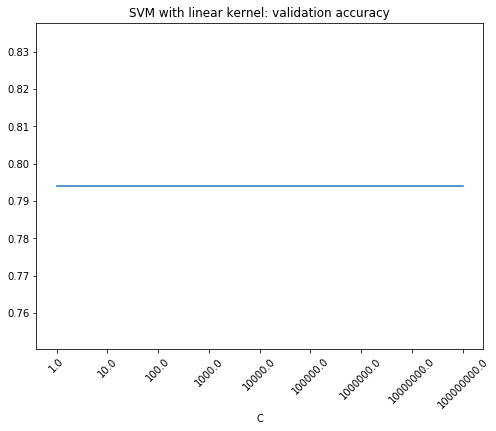

In [53]:
# plot scores
plt.figure(figsize=(8, 6))
plt.plot(scores)
plt.xticks(np.arange(len(C_range)), C_range, rotation=45)
plt.xlabel('C')
plt.title('SVM with linear kernel: validation accuracy')
plt.show()

### Performance evaluation on test set

In [54]:
# instantiate and train a SVM model with linear kernel the C parameter found previously (without probability estimation)
clf = SVC(kernel='linear', C=grid.best_params_['C'])
%time clf.fit(X_train_dtm, y_train)

Wall time: 7.81 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [55]:
# make class predictions for X_test_dtm
%time y_pred_class = clf.predict(X_test_dtm)

Wall time: 1.89 s


In [56]:
# calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy is: {}'.format(accuracy))

accuracy is: 0.804


In [57]:
# print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_class)
print('confusion matrix is:')
print(conf_mat)

confusion matrix is:
[[200  45]
 [ 53 202]]


In [58]:
# import, instantiate and train the model with probability estimation (to compute AUC score)
clf = SVC(kernel='linear', C=grid.best_params_['C'], probability=True)
%time clf.fit(X_train_dtm, y_train)

Wall time: 38.6 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [59]:
# calculate predicted probabilities for X_test_dtm and area under ROC curve
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
AUC = metrics.roc_auc_score(y_test, y_pred_prob)
print('area under ROC curve is: {}'.format(round(AUC,3)))

area under ROC curve is: 0.906


## 3.2. SVM with RBF kernel

### Finding the best parameters with grid-search and cross-validation

We optimize the choice for the penalty parameter C and the kernel coefficient gamma with RBF kernel, by using a 2D grid-search cross-validation.

#### 1st step: large logarithmic grid search

In [60]:
# define the set of parameters
C_range = np.logspace(0, 10, 6)
gamma_range = np.logspace(-11, -1, 6)
param_grid = dict(gamma=gamma_range, C=C_range)

In [61]:
# operate grid search with RBF kernel
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=3, return_train_score=True)
%time grid.fit(X_train_dtm, y_train)

Wall time: 16min 1s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': array([1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01]), 'C': array([1.e+00, 1.e+02, 1.e+04, 1.e+06, 1.e+08, 1.e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [62]:
# print results
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
scores

The best parameters are {'C': 10000.0, 'gamma': 1e-05} with a score of 0.79


array([[0.50333333, 0.50333333, 0.50333333, 0.50333333, 0.75066667,
        0.50466667],
       [0.50333333, 0.50333333, 0.50333333, 0.792     , 0.78333333,
        0.50466667],
       [0.50333333, 0.50333333, 0.794     , 0.79466667, 0.78333333,
        0.50466667],
       [0.50333333, 0.78266667, 0.79333333, 0.79466667, 0.78333333,
        0.50466667],
       [0.50333333, 0.75133333, 0.79333333, 0.79466667, 0.78333333,
        0.50466667],
       [0.50333333, 0.75      , 0.79333333, 0.79466667, 0.78333333,
        0.50466667]])

In [63]:
# Utility function to move the midpoint of a colormap to be around the values of interest
# from http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

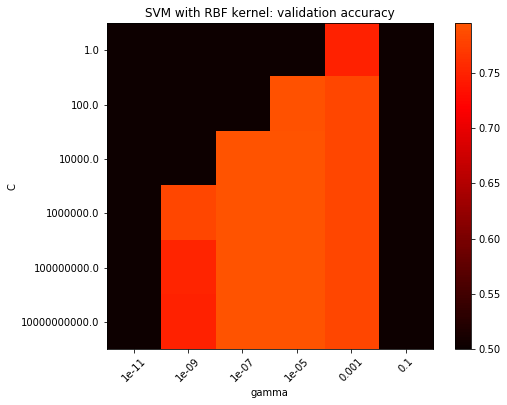

In [64]:
# draw heatmap ()
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.5, midpoint=0.8))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('SVM with RBF kernel: validation accuracy')
plt.show()

#### 2nd step: precise logarithmic grid search on a more precise range chosen from 1st step

In [65]:
# define the set of parameters
C_range = np.logspace(4, 8, 5)
gamma_range = np.logspace(-8, -4, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
param_grid

{'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04]),
 'C': array([1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08])}

In [67]:
# operate grid search with RBF kernel
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=3, return_train_score=True)
%time grid.fit(X_train_dtm, y_train)

Wall time: 10min 25s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04]), 'C': array([1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [68]:
# print results
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
scores

The best parameters are {'C': 10000.0, 'gamma': 0.0001} with a score of 0.80


array([[0.53733333, 0.794     , 0.79466667, 0.79466667, 0.79666667],
       [0.79266667, 0.794     , 0.79333333, 0.79466667, 0.79666667],
       [0.78733333, 0.79333333, 0.79333333, 0.79466667, 0.79666667],
       [0.77933333, 0.79333333, 0.79333333, 0.79466667, 0.79666667],
       [0.77266667, 0.79333333, 0.79333333, 0.79466667, 0.79666667]])

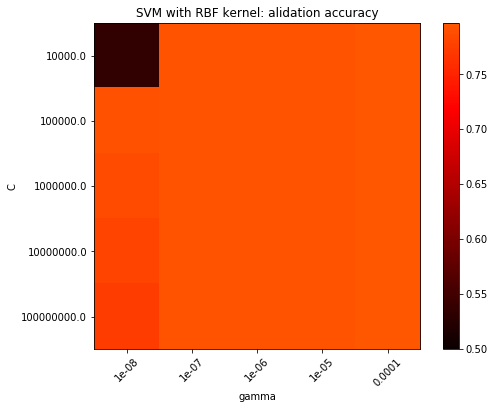

In [69]:
# draw heatmap
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.5, midpoint=0.8))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('SVM with RBF kernel: alidation accuracy')
plt.show()

### Performance evaluation on test set

In [71]:
# instantiate and train a SVM model with RBF kernel and the C and gamma parameters found previously (without probability estimation)
clf = SVC(kernel='rbf', gamma=grid.best_params_['gamma'], C=grid.best_params_['C'])
%time clf.fit(X_train_dtm, y_train)

Wall time: 8.59 s


SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [72]:
# make class predictions for X_test_dtm
%time y_pred_class = clf.predict(X_test_dtm)

Wall time: 1.97 s


In [73]:
# calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy is: {}'.format(accuracy))

accuracy is: 0.804


In [74]:
# print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_class)
print('confusion matrix is:')
print(conf_mat)

confusion matrix is:
[[199  46]
 [ 52 203]]


In [76]:
# import, instantiate and train the model with probability estimation (to compute AUC score)
clf = SVC(kernel='rbf', gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], probability=True)
%time clf.fit(X_train_dtm, y_train)

Wall time: 40.4 s


SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [77]:
# calculate predicted probabilities for X_test_dtm and area under ROC curve
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
AUC = metrics.roc_auc_score(y_test, y_pred_prob)
print('area under ROC curve is: {}'.format(round(AUC,3)))

area under ROC curve is: 0.906


## Class prediction using bidirectional LSTM

In addition of the first methods that are quite common, we wanted to investigate another newer method based on deep learning, so we decided to focus on bidirectional LSTM (<a href=https://maxwell.ict.griffith.edu.au/spl/publications/papers/ieeesp97_schuster.pdf>Schuster and al, 1997</a>). The difference with a simple LSTM is that it agregates the result of a first LSTM whose input is gathered from left to right with another LSTM whose input is gathered from right to left. The purpose is to outperform the performance of a simple LSTM.

RNN are more dedicated to prediction on sequences, yet they can be used for classification by predicting a class for each element of the sequence (each work/token in our case) and then predict a class for the entire sequence (the review) from the prdicted classes of all the elements or some elements. That's what we tried to achieve here.

For this purpose, we used KERAS, a framework that makes use of Tensorflow (or Theano) for python3 (<3.7). In order to fulfil the motivations of reproducible research, both tensorflow (used by KERAS) and numpy seeds are explicitly set.

However, we couldn't train it in a reasonable time (proportionate to our computation power). As a result this test takes only 30 training samples and 20 test samples for a demonstrating purpose. It would have require much more training samples to get interesting results.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

from sklearn.metrics import accuracy_score

#Seeds of KERAS and numpy frozen here
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [ ]:
#to bypass out of memory error on GPU: we run this session on CPU only
#If the gpu has a large enough amount of memory, the content of this cell can be discarded
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
sess = set_session(tf.Session(config=config))

In [ ]:
#A function to return the selected sample among the 1500 of the training test
def get_n(n, X):
    return np.array([X[:,n].tolist()])

In [ ]:
# Reshape the arrays for the lstm
y_tr = y_train.values.reshape(1, y_train.shape[0], 1)
X_tr = X_train_dtm.toarray().reshape(1, X_train_dtm.shape[0], X_train_dtm.shape[1])
y_ts = y_test.values.reshape(1, y_test.shape[0], 1)
X_ts = X_test_dtm.toarray().reshape(1, X_test_dtm.shape[0], X_test_dtm.shape[1])

#In a terminal, we can launch a tool called tensorboard wich monitor the loss diminution and other variables.
#    tensorboard --logdir path_to_current_folder/Graph 

# Create a tensorflow callback in order for tensorboard to vizualise the diminishing loss
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# Create the KERAS model
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=get_n(0, X_tr).shape[1:], merge_mode='concat'))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# Training
for n_sample in range(0, 30):#X_tr.shape[1]):
    model.fit(get_n(n_sample, X_tr), get_n(n_sample, y_tr), epochs=1, batch_size=1, verbose=0, callbacks=[tbCallBack])

# Accuracy
ypred = list()
for n_sample_test in range(0, 20):#X_ts.shape[1]):
    ypred.append(model.predict(get_n(n_sample_test, X_ts)))

print(accuracy_score([[-1] if x.tolist()[0][0][0]<0.5 else [1]  for x in ypred], y_ts[:,0:20][0].tolist()))